### Import libraries needed

In [ ]:
import deeplabcut
from torchvision import *
import torch
from deeplabcut.modelzoo import build_weight_init
import os
import pandas as pd
import json
import yaml
import numpy as np
import csv 
import shutil

Loading DLC 3.0.0rc10...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\Kimmy\anaconda3\envs\DEEPLABCUT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating New DeepLabCut project for model use

In [ ]:
# Loading in skeleton json file that was previously created to add to config file
with open('test_json_file.json', 'r') as f:
    skeleton_data = json.load(f)

In [3]:
# vids = ['D:/UTMB_Project/Dr_Green_Project/Draft_Final_Files\\Camera4_stitched.mp4' , 'D:/UTMB_Project/Dr_Green_Project/Draft_Final_Files\\Camera5_stitched.mp4']
videos = [r'{}'.format(v) for v in skeleton_data['videos']]
print (videos)

['D:/UTMB_Project/Dr_Green_Project/Video_Generation_Rat_in_Chamber.mp4', 'D:/UTMB_Project/Dr_Green_Project/Rat_Tracking_Video_Generation_Request (3).mp4', 'D:/UTMB_Project/Dr_Green_Project/Rat_Tracking_Video_Generation_Request (2).mp4', 'D:/UTMB_Project/Dr_Green_Project/Rat_Video_Generation_Request_Fulfilled.mp4', 'D:/UTMB_Project/Dr_Green_Project/Rat_Tracking_Video_Generation_Request (1).mp4', 'D:/UTMB_Project/Dr_Green_Project/Rat_Video_Generated_Successfully.mp4', 'D:/UTMB_Project/Dr_Green_Project/Video_for_Rat_Tracking_Training (3).mp4', 'D:/UTMB_Project/Dr_Green_Project/Rat_Tracking_Video_Generation_Request.mp4']


In [ ]:
# New project creation 

# Get path of working directory (with slashes forward \ )
wd = r'D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files'
# for videos 
# videos = [r'{}'.format(v) for v in skeleton_data['videos']]

config_path = deeplabcut.create_new_project(
        'Sleap_Rat_test', # Name of Project
        'T',  # Name of scorer
         videos , 
        working_directory= wd,
        copy_videos = False
)    

# Outputs where the config file is located
print(f"Config created at {config_path}")

Created "D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat_test-G-2025-09-05\videos"
Created "D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat_test-G-2025-09-05\labeled-data"
Created "D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat_test-G-2025-09-05\training-datasets"
Created "D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat_test-G-2025-09-05\dlc-models"
Attempting to create a symbolic link of the video ...
Symlink creation impossible (exFat architecture?): copying the video instead.
D:\UTMB_Project\Dr_Green_Project\Video_Generation_Rat_in_Chamber.mp4 copied to D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat_test-G-2025-09-05\videos\Video_Generation_Rat_in_Chamber.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
D:\UTMB_Project\Dr_Green_Project\Rat_Tracking_Video_Generation_Request (3).mp4 copied to D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat_test-G-2025-09-05\videos\Rat_Track

In [9]:
# Load config file to add in custom body parts and skeleton to the config file

# Loads config file 
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Skeleton and bodypart data are being set to the config files bodypart and skeleton
config['bodyparts'] = skeleton_data['bodyparts']
config['skeleton'] = skeleton_data['skeleton']


# Save updated config file
with open(config_path, 'w') as f:
    yaml.dump(config, f)

# Prints content of config file
print(f"This is updated config file: {config}")

This is updated config file: {'Task': 'Sleap_Rat_test', 'scorer': 'G', 'date': 'Sep5', 'multianimalproject': False, 'identity': None, 'project_path': 'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Sleap_Rat_test-G-2025-09-05', 'engine': 'pytorch', 'video_sets': {'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Sleap_Rat_test-G-2025-09-05\\videos\\Video_Generation_Rat_in_Chamber.mp4': {'crop': '0, 1280, 0, 720'}, 'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Sleap_Rat_test-G-2025-09-05\\videos\\Rat_Tracking_Video_Generation_Request (3).mp4': {'crop': '0, 1280, 0, 720'}, 'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Sleap_Rat_test-G-2025-09-05\\videos\\Rat_Tracking_Video_Generation_Request (2).mp4': {'crop': '0, 1280, 0, 720'}, 'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Sleap_Rat_test-G-2025-09-05\\videos\\Rat_Video_Generation_Request_Fulfilled.mp4': {'crop': '0, 1280, 0, 720'}, 'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Sleap

### For existing projects (continue working on project without initializing a new project)

In [2]:

# Run this cell only when project exists 


# Get config file path (usually in the project file)
config_path = r'D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat-G-2025-08-31\config.yaml'

#Loads project 
with open(config_path,'r') as f :
   config = yaml.safe_load(f)

    

### Converting SLEAP csv to DLC format

In [ ]:
# for loop for all videos using config['video_sets] to create all csv files to deeplabcut format

def convert_sleap_to_dlc_format(sleap_csv_path, output_path, config, video_name):
    # Load SLEAP data
    sleap_df = pd.read_csv(sleap_csv_path)
 
    bodyparts = config['bodyparts']
    # Create header rows before 
    scorer_row = ['scorer'] + [config['scorer']] * (len(bodyparts) * 2)
    bodyparts_row = ['bodyparts'] + [bp for bp in bodyparts for _ in range(2)]
    coords_row = ['coords'] + ['x', 'y'] * len(bodyparts)
    
    final_data = [scorer_row, bodyparts_row, coords_row]

    
    for idx, row in sleap_df.iterrows():
        # print(f"this is index {idx} and row \n{row}")

        # Gets the frame number from the csv file 
        frame_num = int(row['frame_idx'])

        # Name of image that contains the frame number with extension (later will be used for frame extraction)
        img_name = f"img{frame_num:03d}.png"
        img_path = f"labeled-data/{video_name}/{img_name}"  # Note the forward slashes
       
       # Row name will be the image path 
        data_row = [img_path]
     
        # Add x,y coordinates for each bodypart in order
        for bodypart in bodyparts:
            x_col = f"{bodypart}.x"
            y_col = f"{bodypart}.y"
            
            if x_col in row and y_col in row:
                x_val = row[x_col] if not pd.isna(row[x_col]) else None
                y_val = row[y_col] if not pd.isna(row[y_col]) else None
                data_row.extend([x_val, y_val])
            else:
                data_row.extend([None, None])
        print(f"this is the row {data_row}")
        final_data.append(data_row)

     # Save to CSV
    with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(final_data)
    
    print(f"CSV saved with {len(sleap_df)} frames")
    

# Goes through all videos that are in the video_sets from config file
for video in config['video_sets']:
    video_name = os.path.splitext(os.path.basename(video))[0]

    convert_sleap_to_dlc_format(
        f'{video_name}.csv',  # Sleap file name needs to be exactly same name as the video (spacing and all), files need to be in working directory
        f'CollectedData_{config['scorer']}.csv', # Gives the csv file with the name of scorer (required for )
        config,
        video_name
    )
    # Moves source file (our csv file that contains all labels) to destination (to corresponding folder of the video)
    # Note that in the destination it will be f"./Name_Of_Project_folder/labeled-data/{video_name}" this format.                                                      
    shutil.move(f"./CollectedData_{config['scorer']}.csv",f"./Sleap_Rat_test-G-2025-09-05/labeled-data/{video_name}" )
    
# Check labeled-data folder and verify each file is in correct folder
print("Done")

### Manually extract frames from csv file 

In [ ]:
import cv2
import os
import pandas as pd

def extract_frames_from_csv(video_path, csv_path, project_path, video_name):
    """Extract frames based on CSV data"""
    
    # Read CSV (skip the header rows)
    df = pd.read_csv(csv_path, skiprows=3, header=None)
    
    # Get frame numbers from image paths
    frame_numbers = []
    for img_path in df.iloc[:, 0]:  # First column has image paths
        if isinstance(img_path, str) and 'img' in img_path:
            # Extract frame number: labeled-data/Camera4_stitched/img002083.png -> 2083
            frame_num_str = img_path.split('img')[1].split('.')[0]
            frame_numbers.append(int(frame_num_str))
    
    print(f"Extracting frames: {frame_numbers}")
   
    # Create output directory
  
    output_dir = os.path.join(project_path, "labeled-data", video_name)
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video has {total_frames} total frames")
    
    for frame_num in frame_numbers:
        if frame_num < total_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            
            if ret:
                img_name = f"img{frame_num:03d}.png"
                img_path = os.path.join(output_dir, img_name)
                cv2.imwrite(img_path, frame)
                print(f"Extracted frame {frame_num}")
            else:
                print(f" Failed to read frame {frame_num}")
        else:
            print(f"✗ Frame {frame_num} exceeds video length ({total_frames})")
    
    cap.release()
    print(f"Frames saved to: {output_dir}")

# Extract frames of each video
for video in config['video_sets']:
    video_name = os.path.splitext(os.path.basename(video))[0]
    extract_frames_from_csv(
        video,  # video file

        # format of path /project_name/labeled-data/video_name/CollectedData_scorername.csv
        f'./Sleap_Rat_test-G-2025-09-05/labeled-data/{video_name}/CollectedData_{config['scorer']}.csv', # CSV file containing frame numbers
        
         # Project directory 
        os.path.dirname(config_path),
        video_name
    )



In [18]:
''' Converting to format that DeepLabCut understands after manually extracting frames (make sure the csv file with image paths and
 coordinates is in the labeled data folder ) '''
deeplabcut.convertcsv2h5(config_path, userfeedback=False,scorer=config['scorer'])


## Finetune Model for SuperAnimal

Creating dataset and initializing weights based on preferences

In [ ]:
superanimal_name = 'superanimal_quadruped'

config_path = os.path.join(os.getcwd(),"Sleap_Rat-G-2025-08-31", "config.yaml")
superanimal_transfer_learning_shuffle = 1
weight_init = build_weight_init(
            cfg = config_path,
            super_animal= superanimal_name,
            model_name='hrnet_w32',
            detector_name='fasterrcnn_resnet50_fpn_v2',
            with_decoder=False
)


deeplabcut.create_training_dataset(config_path, Shuffles=[superanimal_transfer_learning_shuffle], weight_init=weight_init, net_type='hrnet_w32')



[(0.95,
  1,
  (array([ 18, 170, 107,  98, 177, 182,   5, 146,  12, 152,  61, 125, 180,
          154,  80,   7,  33, 130,  37,  74, 183, 145,  45, 159,  60, 123,
          179, 185, 122,  44,  16,  55, 150, 111,  22, 189, 129,   4,  83,
          106, 134,  66,  26, 113, 168,  63,   8,  75, 118, 143,  71, 124,
          184,  97, 149,  24,  30, 160,  40,  56, 131,  96, 181,  19, 153,
           92,  54, 163,  51,  86, 139,  90, 137, 101, 144,  89, 109,  14,
           27, 141, 187,  46, 138, 195, 108,  62,   2,  59, 136, 197,  43,
           10, 194,  73, 196, 178, 175, 126,  93, 112, 158, 191,  50,   0,
           94, 110,  95,  64, 167,  41,  69,  49,  48,  85,  13, 161,  23,
          186, 135,  20,  15,  78, 104,  52, 100,  76,   3, 116, 164, 198,
            6,  68,  84, 121, 155, 171, 156,  91, 199,  11, 119, 102,  35,
           57,  65,   1, 120, 162,  42, 105, 132, 173,  17,  38, 133,  53,
          157, 128,  34,  28, 114, 151,  31, 166, 127, 176,  32, 142, 169,
          14

Training 

In [ ]:
help(deeplabcut.train_network)

In [ ]:
deeplabcut.train_network(config_path,
                         shuffle=1,
                          epochs=50,
                          save_epochs=10,
                          superanimal_name=superanimal_name,
                          batch_size= 8,
                          keepdeconvweights=False,
                          device="cuda:0",
                          superanimal_transfer_learning=True
                          )

Training with configuration:
data:
  bbox_margin: 20
  colormode: RGB
  inference:
    normalize_images: True
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
  train:
    affine:
      p: 0.5
      rotation: 30
      scaling: [0.5, 1.25]
      translation: 0
    crop_sampling:
      width: 448
      height: 448
      max_shift: 0.1
      method: hybrid
    gaussian_noise: 12.75
    motion_blur: True
    normalize_images: True
    auto_padding:
      pad_width_divisor: 32
      pad_height_divisor: 32
device: auto
metadata:
  project_path: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat-G-2025-08-31
  pose_config_path: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat-G-2025-08-31\dlc-models-pytorch\iteration-0\Sleap_RatAug31-trainset95shuffle1\train\pytorch_config.yaml
  bodyparts: ['head', 'nose', 'spine1', 'spine2', 'spine3', 'tailbase', 'tail1', 'tail2', 'tail_tip', 'L_hip', 'L_backpaw', 'R_backpaw', 'L_shoulder', 'R_frontpaw', 'R_sh

Evaluating 

In [ ]:
help(deeplabcut.evaluate_network)

In [ ]:
deeplabcut.evaluate_network(config_path, Shuffles=[superanimal_transfer_learning_shuffle],
                            plotting="individual", comparisonbodyparts='all', show_errors= True, 
                             per_keypoint_evaluation=True )

# deeplabcut.analyze_videos(config_path, ['/path/to/your/video.mp4'], videotype='mp4')


Evaluation scorer: DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40


100%|██████████| 10/10 [00:00<00:00, 31.54it/s]


Evaluation results file: DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40-results.csv
Evaluation results for DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40-results.csv (pcutoff: 0.6):
train rmse            15.12
train rmse_pcutoff      NaN
train mAP             88.67
train mAR             90.89
test rmse             28.62
test rmse_pcutoff       NaN
test mAP              79.66
test mAR              81.00
Name: (0.95, 1, 40, -1, 0.6), dtype: float64


In [3]:
deeplabcut.extract_save_all_maps(config=config_path, device="cuda:0", all_paf_in_one=False, Indices=[0, 25,50,75,100,125,150,175,199])

Saving plots...


100%|██████████| 9/9 [00:17<00:00,  1.96s/it]


Analyzing video using trained model

In [ ]:
help(deeplabcut.analyze_videos)

In [24]:
deeplabcut.analyze_videos(
    config_path,
    [r"D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched.mp4"],
    save_as_csv= True
)

Successfully loaded snapshot: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat-G-2025-08-31\dlc-models-pytorch\iteration-0\Sleap_RatAug31-trainset95shuffle1\train\snapshot-best-040.pt
Analyzing videos with D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Sleap_Rat-G-2025-08-31\dlc-models-pytorch\iteration-0\Sleap_RatAug31-trainset95shuffle1\train\snapshot-best-040.pt
Using scorer: DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40
Starting to analyze D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched.mp4
Video metadata: 
  Overall # of frames:    161790
  Duration of video [s]:  5393.00
  fps:                    30.0
  resolution:             w=1280, h=720

Running pose prediction with batch size 8


100%|██████████| 161790/161790 [2:03:20<00:00, 21.86it/s] 


Saving results in D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitchedDLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40.h5 and D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitchedDLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.



'DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40'

## Define a function to get an image from the video given frame index (DONE)

Frame exists!
This is image D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\img9555.png


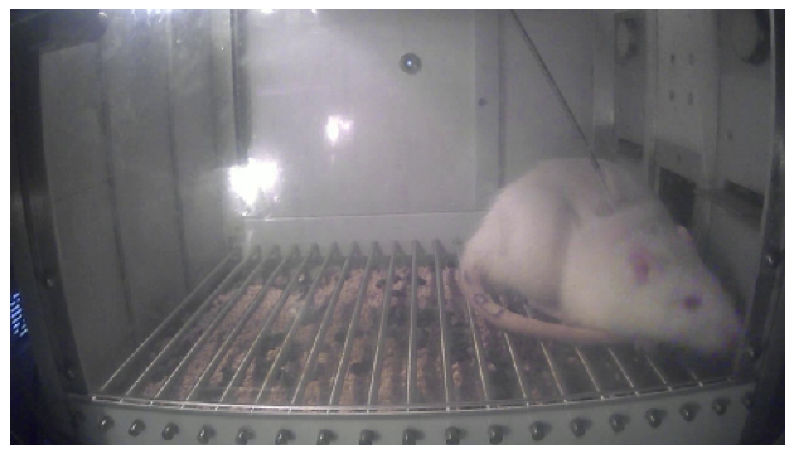

In [24]:
import cv2
import os
import matplotlib.pyplot as plt 

#return image , gets video path, idx frame, and output directory 
def get_image_from_video(video_path, idx_frame, output_dir):
    count = 0
    # Opens the video
    cap = cv2.VideoCapture(video_path)
    #  Make folder in the directory the video is in 
    os.makedirs(output_dir, exist_ok=True)


    # checks if video is open
    if not cap.isOpened():
        print("ERROR: Could not open")
        return -1
    # set to specify the frame 
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx_frame)

    # reads the frame 
    ret, frame = cap.read()

    # if ret is true, frame was found then save and return 
    if ret :
        # output directory with image name
        filename = f"img{idx_frame}.png"
        filepath= os.path.join(output_dir,filename)
        # checks if the image exists in the directory, if it is then it just returns the frame 
        if os.path.exists(filepath):
           print("Frame exists!")
           cap.release()
           return frame , filepath
        else:
            cv2.imwrite(filepath, frame )
            print (f" Frame {idx_frame} saved successfully")
    else:
        print(f"Error: Could not read frame {idx_frame}.")
    # Release the video capture object 
    cap.release()
    return frame, filepath




# Set desired frame index
idx_frame = 9555
# Set the video path 
video_path = r"D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched.mp4"
# Only gets the name of video
videoname = os.path.splitext(os.path.basename(video_path))[0]
# gets path where the video is currently in
output_dir =os.path.join(os.path.dirname(video_path),videoname)
# output_dir = r""

image, image_path = get_image_from_video(video_path,idx_frame,output_dir)

print(f"This is image {image_path}")
# Show the image if it exists
if image is not None:
   
   frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

   # Display
   plt.figure(figsize=(10,6)) 
   plt.imshow(frame)
   plt.axis('off')
   plt.show()



 ## Function to make a prediction using image and model as input (DONE) dlc has a function for it

In [3]:
# directory path of the folder where the images are stored in 
directory_path = r'D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched'
# can give directory of images without specifying each individual image into another variable
predictions_list = deeplabcut.analyze_images(config_path, images= directory_path, snapshot_index=config['snapshotindex'], shuffle = 1, device = None )


100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Setting output directory to D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched
Saving predictions to D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\image_predictions_DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40.h5


## Section for plotting predictions (done)

Function for label image

In [4]:
# make a plot for a single image
def plot_image_with_predict(img , data , bodyparts, confidence, img_path):
    
    colors = create_bodypart_colors(bodyparts)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)

    # loop through number of bodyparts and access the coordinates by the number of bodyparts as it should match the number of coordinates
    legend_elements = []
    for coordinates in data:

        # print(f"coordinates data {coordinates}")
        
        # this is where the plot for each bodypart will be done individually
        # Loop through each body part and then plot

        for i in range(len(bodyparts)):

            # print(f"bodypart {bodyparts[i]}")
            # print(f"x {coordinates[i][0]}, y {coordinates[i][1]}, likelihood {coordinates[i][2]}")
            x = coordinates[i][0]
            y = coordinates[i][1]
            conf = coordinates[i][2]
            if conf >= confidence:
                color = colors[bodyparts[i]]
                
                # Plot point
                ax.scatter(x, y, c=[color], s=25, edgecolors='white', linewidth=2, zorder=3)
                
                # Add label
                ax.annotate(bodyparts[i], (x, y), xytext=(5, 5), textcoords='offset points',
                            fontsize=6, color='white', fontweight='bold')
                # Add to legend
                legend_elements.append(patches.Patch(color=color, label=f'{bodyparts[i]} ({conf:.2f})'))

    # Add legend
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), 
            fontsize=8, title='Bodyparts (confidence)')
    
    # Set title 
    ax.set_title(f'DeepLabCut Predictions\n{os.path.basename(img_path)}\nConfidence threshold: {confidence}', 
                fontsize=12)
    ax.axis('off')

    # Path of the image path folder 
    output_dir = os.path.join(os.path.dirname(img_path),f"{os.path.basename(os.path.dirname(img_path))}_labeled")

    # Create folder for saving image predictions
    os.makedirs(output_dir, exist_ok=True)

    # Path where the image will be saved (has image name)
    save_path = os.path.join(os.path.dirname(img_path),f"{os.path.basename(os.path.dirname(img_path))}_labeled", f"prediction_{os.path.basename(img_path)}")

    # Saving the image
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    print(f"Saved visualization to: {save_path}")
        
    plt.tight_layout()
    plt.show()
    



Function for creating bodypart colors

In [5]:
# function gets colors of body part points based on how many bodyparts there is 
def create_bodypart_colors(bodyparts):
    """Create a color map for bodyparts"""
    # Generate distinct colors for each bodypart
    colors = plt.cm.tab20(np.linspace(0, 1, len(bodyparts)))
    color_dict = dict(zip(bodyparts, colors))
    return color_dict

Function for reading image

In [6]:
def read_image(image_path):
       
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Create dummy image if actual image not found
        print(f"Image not found: {image_path}. Creating dummy image.")
        img = np.ones((600, 800, 3), dtype=np.uint8) * 128
    
    return img

Saved visualization to: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\Camera2_stitched_labeled\prediction_img12000.png


Saved visualization to: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\Camera2_stitched_labeled\prediction_img15000.png


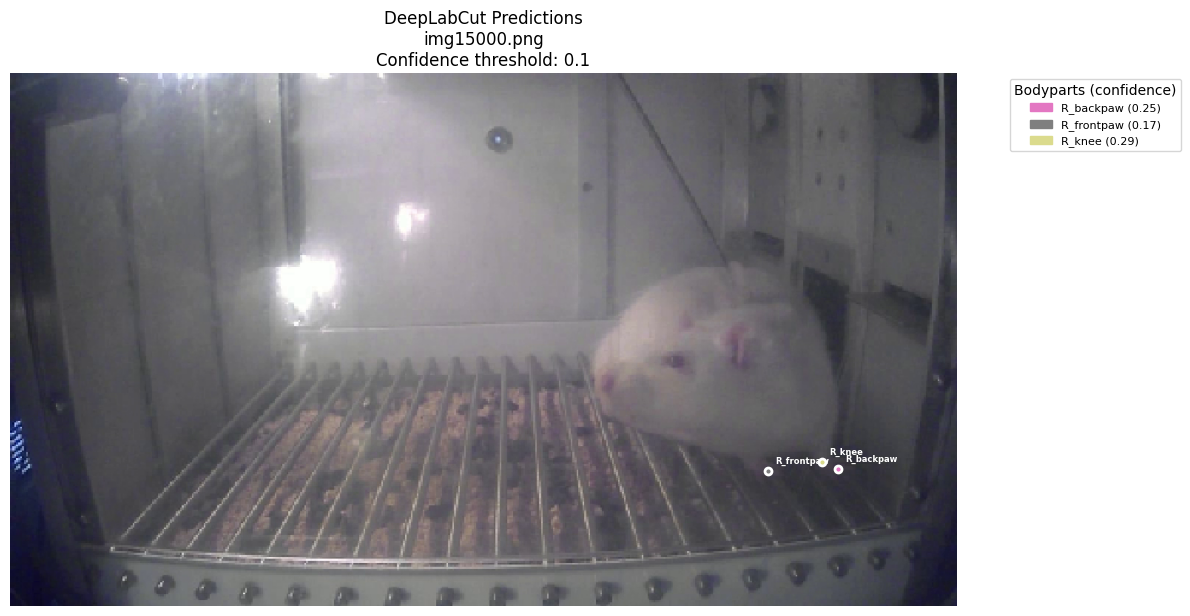

Saved visualization to: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\Camera2_stitched_labeled\prediction_img20000.png


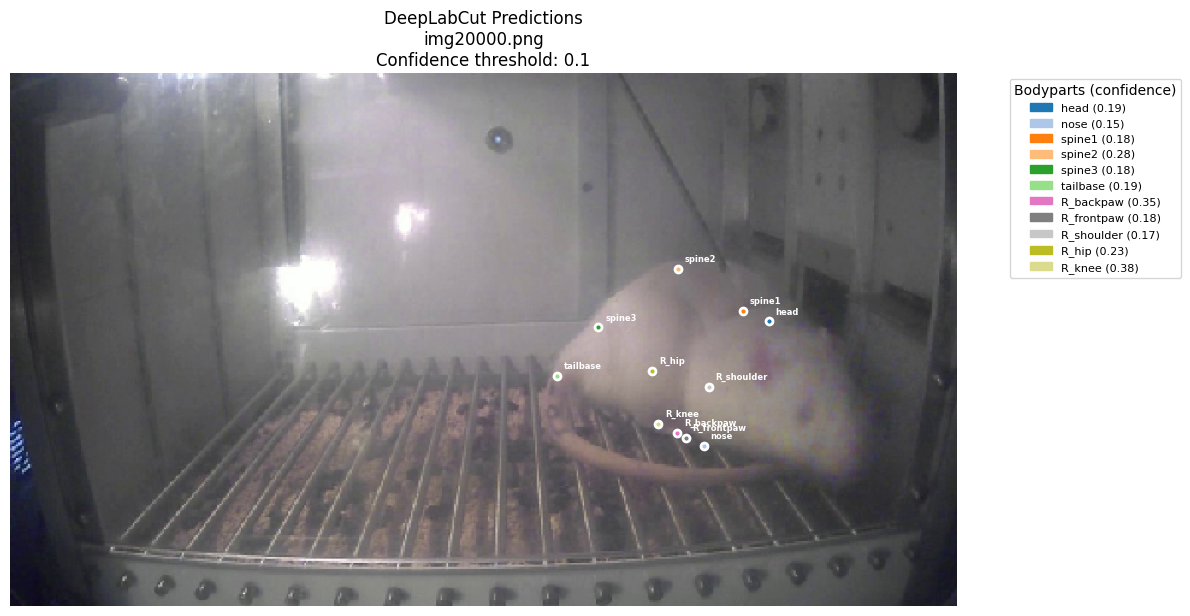

Saved visualization to: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\Camera2_stitched_labeled\prediction_img2560.png


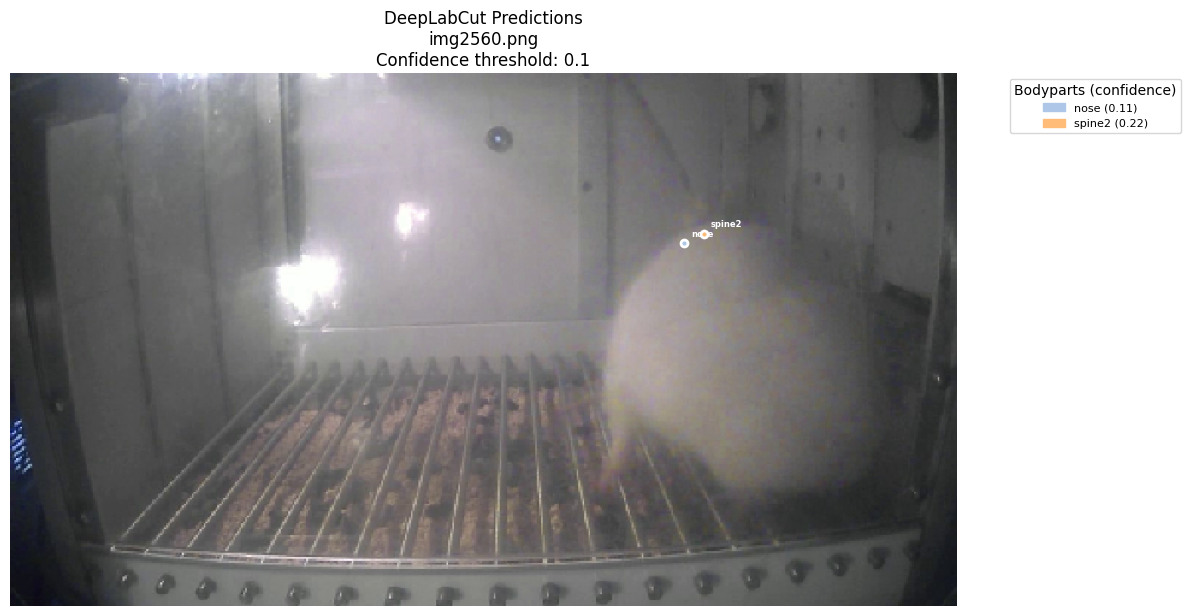

Saved visualization to: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\Camera2_stitched_labeled\prediction_img5620.png


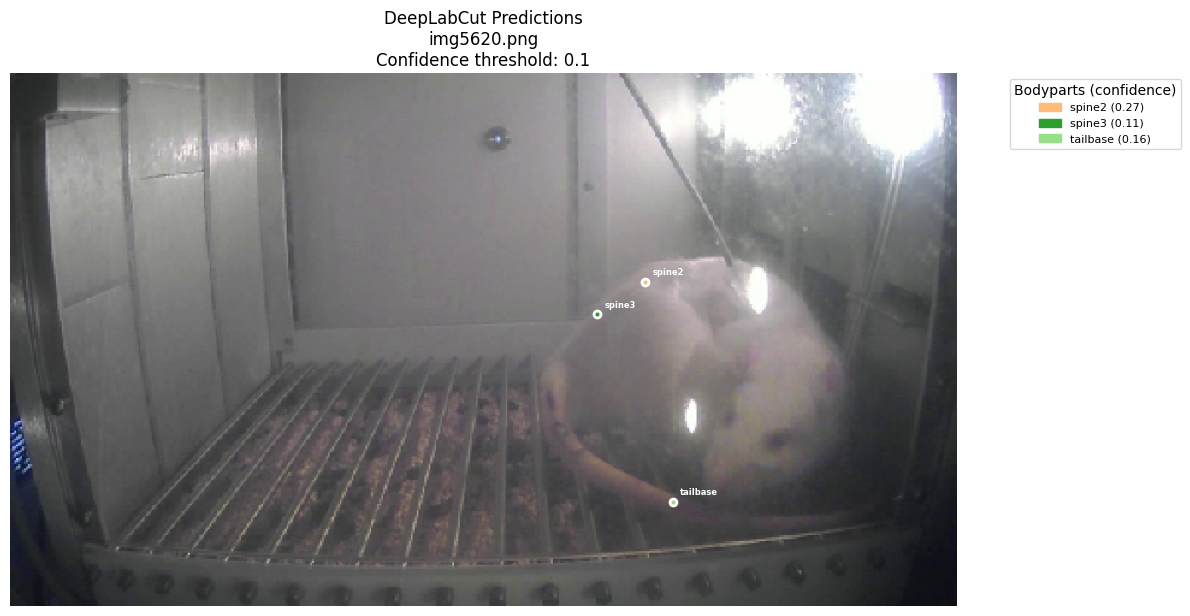

Saved visualization to: D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\Camera2_stitched_labeled\prediction_img9555.png


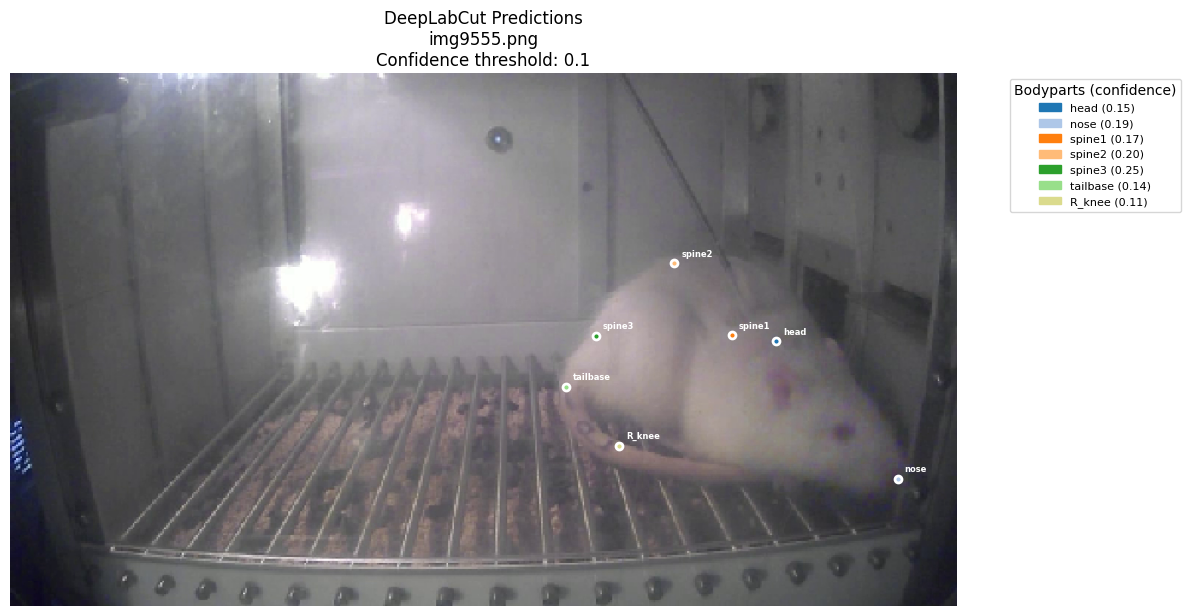

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import deeplabcut 
import os 
import glob 
import cv2
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

bodyparts = config['bodyparts']

confidence_threshold = 0.1


'''MAIN CALL FOR FUNCTION'''
# go through each image path  (path of image and predictions) ex ): 'D:\\UTMB_Project\\Dr_Green_Project\\Draft_Final_Files\\Camera2_stitched\\img12000.png' : bodyparts
for img_path in predictions_list:
  
  
   
    pred = predictions_list[img_path]['bodyparts'] 

    img = read_image(img_path) 
    
    content = plot_image_with_predict(img, pred, bodyparts, confidence_threshold, img_path)
    
    
    


In [ ]:
for i in in range(len(contents)):
    image_path = contents[i]
    predictions = predictions_list[i]
    # read image
    image = read_image(image_path)
    image_with_pred = plot_image_with_predict(image, predictions)
    ## plot

    # save it

 ## Function to show prediction labels on the image using hdf file (original code)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import deeplabcut 
import os 
import glob 
import cv2
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

# function gets colors of body part points based on how many bodyparts there is 
def create_bodypart_colors(bodyparts):
    """Create a color map for bodyparts"""
    # Generate distinct colors for each bodypart
    colors = plt.cm.tab20(np.linspace(0, 1, len(bodyparts)))
    color_dict = dict(zip(bodyparts, colors))
    return color_dict


def extract_predictions(eval_data):
    '''EXTRACTING PREDICTIONS INFO FROM THE HDF FILE THAT CONTAINS THE PREDICTIONS'''

    predictions = {}
    scorer = eval_data.columns.levels[0][0]
    # print(f"Scorer: {scorer}")
    # Try different ways to get bodyparts depending on column structure
    if eval_data.columns.nlevels == 4:
        # Standard DLC format: (scorer, individual, bodypart, coords)
        individual = eval_data.columns.levels[1][0]  # Usually 'animal' or individual name
        bodyparts = eval_data.columns.levels[2].tolist()
        # print(f"Individual: {individual}")
        # print(f"4-level structure - Bodyparts found: {bodyparts}")
        
        for bodypart in bodyparts:
            try:
                x_coords = eval_data[(scorer, individual, bodypart, 'x')].values
                y_coords = eval_data[(scorer, individual, bodypart, 'y')].values
                likelihoods = eval_data[(scorer, individual, bodypart, 'likelihood')].values
                
                predictions[bodypart] = {
                    'x': x_coords,
                    'y': y_coords,
                    'likelihood': likelihoods
                }
                # print(f"Successfully extracted data for {bodypart}")
            except KeyError as e:
                print(f"KeyError for bodypart {bodypart}: {e}")
                # Try alternative column names
                try:
                    x_coords = eval_data[(scorer, individual, bodypart, 'x')].values
                    y_coords = eval_data[(scorer, individual, bodypart, 'y')].values
                    likelihoods = eval_data[(scorer, individual, bodypart, 'probability')].values  # Sometimes it's 'probability'
                    
                    predictions[bodypart] = {
                        'x': x_coords,
                        'y': y_coords,
                        'likelihood': likelihoods
                    }
                    # print(f"Successfully extracted data for {bodypart} using 'probability'")
                except KeyError:
                    print(f"Warning: Could not find data for bodypart {bodypart}")
    
    elif eval_data.columns.nlevels == 3:
        # Alternative format: (scorer, bodypart, coords)
        bodyparts = eval_data.columns.levels[1].tolist()
        # print(f"3-level structure - Bodyparts found: {bodyparts}")
        
        for bodypart in bodyparts:
            try:
                x_coords = eval_data[(scorer, bodypart, 'x')].values
                y_coords = eval_data[(scorer, bodypart, 'y')].values
                likelihoods = eval_data[(scorer, bodypart, 'likelihood')].values
                
                predictions[bodypart] = {
                    'x': x_coords,
                    'y': y_coords,
                    'likelihood': likelihoods
                }
                # print(f"Successfully extracted data for {bodypart}")
            except KeyError as e:
                print(f"KeyError for bodypart {bodypart}: {e}")
                try:
                    likelihoods = eval_data[(scorer, bodypart, 'probability')].values
                    predictions[bodypart] = {
                        'x': eval_data[(scorer, bodypart, 'x')].values,
                        'y': eval_data[(scorer, bodypart, 'y')].values,
                        'likelihood': likelihoods
                    }
                    # print(f"Successfully extracted data for {bodypart} using 'probability'")
                except KeyError:
                    print(f"Warning: Could not find data for bodypart {bodypart}")

    return bodyparts, predictions

            

# Function that adds the prediction labels to frame 
def generate_prediction_label (image_path,predictions,bodyparts,image_idx, confidence_threshold, save_path):


    """PLOT PREDICTION OF IMAGE"""
    print ("PLOTTING PREDICTIONS ON IMAGE")
    # Load image
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Create dummy image if actual image not found
        print(f"Image not found: {image_path}. Creating dummy image.")
        img = np.ones((600, 800, 3), dtype=np.uint8) * 128
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    
    # Get colors for bodyparts
    colors = create_bodypart_colors(bodyparts)

   
    print("NOW PLOTTING BODY PARTS")

  
    # Plot bodyparts

    legend_elements = []
    for bodypart in bodyparts:
        if bodypart in predictions:
            x = predictions[bodypart]['x'][image_idx]
            y = predictions[bodypart]['y'][image_idx]
            conf = predictions[bodypart]['likelihood'][image_idx]
            
            if conf >= confidence_threshold:
                color = colors[bodypart]
                
                # Plot point
                ax.scatter(x, y, c=[color], s=25, edgecolors='white', linewidth=2, zorder=3)
                
                # Add label
                ax.annotate(bodypart, (x, y), xytext=(5, 5), textcoords='offset points',
                            fontsize=6, color='white', fontweight='bold')
                # Add to legend
                legend_elements.append(patches.Patch(color=color, label=f'{bodypart} ({conf:.2f})'))
               

    # Add legend
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), 
              fontsize=8, title='Bodyparts (confidence)')
    
    # Set title
    ax.set_title(f'DeepLabCut Predictions\nImage: {os.path.basename(image_path)}\nConfidence threshold: {confidence_threshold}', 
                fontsize=12)
    ax.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to: {save_path}")
    
    plt.show()
    print("FINISHED PLOT PREDICTIONS ON IMAGE")





# Direct video path 
video =r"D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched.mp4"

# Only get the name of the video excluding the extenstion like .mp4, .mki, .mpv
videoname = os.path.splitext(os.path.basename(video_path))[0]

# Get video path of folder where the images(video frames) are  
# then check if video folder exist with the prediction file, if not let the user know that there is no predictions for that
video_path = os.path.join(os.path.dirname(video),videoname)


if os.path.exists(video_path) and glob.glob(os.path.join(video_path, "*.h5")): 

    # Load the detailed evaluation data typically in a h5 file,this is the file containing the predictions 
    data = pd.read_hdf(os.path.join(video_path, 
                                    'image_predictions_DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40.h5'))
    
    # Set the confidence threshold 
    confidence_threshold = 0.1
    
    # Gets the list of images that were predicted from the hdf file
    image_names = data.index.tolist()

    # extracts the predictions from the hdf file 
    bodyparts, predictions = extract_predictions(data)
    # Gets the list of images that were predicted from the hdf file
    image_names = data.index.tolist()

    # Extract the image paths properly
    img_paths = []
    for s in image_names:
        if isinstance(s, (list, tuple)):
            # If s is a list/tuple, join the parts
            img = '/'.join(s)
        else:
            # If s is already a string, use it directly
            img = str(s)
        img_paths.append(img)

    total_images = len(img_paths)

    # Access the image predictions as index since the bodypart coordinates for each image are retrieved sequential
    for idx in range(total_images):
        img_path = img_paths[idx]
        
        # Extract filename from the path
        filename = os.path.basename(img_path)
      
        # Construct full path to image
        if video_path:
            full_image_path = os.path.join(video_path, filename)
        else:
            full_image_path = img_path
        output_dir = os.path.join(video_path,f'{videoname}_labeled_predictions')
        save_path = None
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            save_path = os.path.join(output_dir, f'visualization_{filename}')

        print(f"Visualizing image {str(idx+1)}/{str(total_images)}: {filename}")
        generate_prediction_label(full_image_path, predictions, bodyparts, idx, 
                                confidence_threshold, save_path)

# if video folder exists but there is no prediction made
elif os.path.exists(video_path):
    print("No prediction for video exists")
else:
    print("No folder for video exists")


In [14]:
import os

video_path =os.path.basename(r"D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched.mp4")
print(video_path)

Camera2_stitched.mp4


In [37]:
data = pd.read_hdf(r"D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched\image_predictions_DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40.h5")
import pprint

# coords contains the image path for the image so that should be fine 

print(data)
# pprint.pprint(data)

scorer                                             DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40  \
individuals                                                                                      animal   
bodyparts                                                                                          head   
coords                                                                                                x   
D:\UTMB_Project\Dr_Green_Project\Draft_Final_Fi...                                        1037.863281     
D:\UTMB_Project\Dr_Green_Project\Draft_Final_Fi...                                         801.863281     
D:\UTMB_Project\Dr_Green_Project\Draft_Final_Fi...                                        1026.174805     
D:\UTMB_Project\Dr_Green_Project\Draft_Final_Fi...                                         961.781250     
D:\UTMB_Project\Dr_Green_Project\Draft_Final_Fi...                                        1028.980469     
D:\UTMB_Project\Dr_Green_Project\Draf

In [40]:
data.columns.levels[2]

Index(['L_backpaw', 'L_frontpaw', 'L_hip', 'L_knee', 'L_shoulder', 'R_backpaw',
       'R_frontpaw', 'R_hip', 'R_knee', 'R_shoulder', 'head', 'nose', 'spine1',
       'spine2', 'spine3', 'tail1', 'tail2', 'tail_tip', 'tailbase'],
      dtype='object', name='bodyparts')

In [ ]:
# contains 4 levels

# level 2 contains the body parts data.columns.levels[2]

# level 3 contains likelihood, x, y  data.columns.levels[3]
bd = data
# print(bd)
for i in bd:
    for x in i:
        print(x)

In [ ]:
import os 
import glob
# this is used to access the image and its body parts which is why it is considered idx since it is then enumerated to index number
image_names = data.index.tolist()
predictions = {}
scorer = data.columns.levels[0][0]
# print(f"Scorer: {scorer}")
individual = data.columns.levels[1][0]  # Usually 'animal' or individual name
bodyparts = data.columns.levels[2].tolist()
# print(f"Individual: {individual}")
# print(f"4-level structure - Bodyparts found: {bodyparts}")

# print(f"This is the list of images names {image_names}")
for bodypart in bodyparts:
    try:
        # gets all x and y  values of bodyparts and their likelihood and assign it to predictions 
        x_coords = data[(scorer, individual, bodypart, 'x')].values
        y_coords = data[(scorer, individual, bodypart, 'y')].values
        likelihoods = data[(scorer, individual, bodypart, 'likelihood')].values
        # print(f" This is x_coords info {x_coords}")
        # print(f" This is y_coords info {y_coords}")
        predictions[bodypart] = {
            'x': x_coords,
            'y': y_coords,
            'likelihood': likelihoods
        }
        # print(f"Successfully extracted data for {bodypart}")
        
    except KeyError as e:
        print(f"KeyError for bodypart {bodypart}: {e}")
        # Try alternative column names
        try:
            x_coords = data[(scorer, individual, bodypart, 'x')].values
            y_coords =data[(scorer, individual, bodypart, 'y')].values
            likelihoods = data[(scorer, individual, bodypart, 'probability')].values  # Sometimes it's 'probability'
            
            predictions[bodypart] = {
                'x': x_coords,
                'y': y_coords,
                'likelihood': likelihoods
            }
            print(f"Successfully extracted data for {bodypart} using 'probability'")
        except KeyError:
            print(f"Warning: Could not find data for bodypart {bodypart}")
# image_idx = 0 
# bodypart = 'nose'

# x = predictions[bodypart]['x'][image_idx]
# x_no = predictions[bodypart]['x']
# print(f"this is x with idx {x} and x without idx {x_no}")
# y = predictions[bodypart]['y'][image_idx]
# y_no = predictions[bodypart]['y']
# print(f"this is y with idx {y} and x without idx {y_no}")
# x_coords = data[(scorer, individual, bodypart, 'x')]
# y_coords = data[(scorer, individual, bodypart, 'y')]
# likelihoods = data[(scorer, individual, bodypart, 'likelihood')].values
# print(f" This is x_coords info {x_coords}")
# print(f" This is y_coords info {y_coords}")

video =r"D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched.mp4"
videoname = os.path.splitext(os.path.basename(video_path))[0]
video_path = os.path.join(os.path.dirname(video),videoname)
print(f" this is the video path {video_path}")
if os.path.exists(video_path) and glob.glob(os.path.join(video_path, "*.h5")): 
    # Load the detailed evaluation data
    # eval_data = pd.read_hdf(os.path.join(evaluation_folder, 
    #                                     'Camera2_stitchedDLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40.h5'))

    # Gets the list of images that were predicted from the hdf file
    image_names = data.index.tolist()

    # extracts the predictions from the hdf file 
    bodyparts, predictions = extract_predictions(data)
# if video folder exists but there is no prediction made
elif os.path.exists(video_path):
    print("No prediction for video exists")
else:
    print("No folder for video exists")

 this is the video path D:\UTMB_Project\Dr_Green_Project\Draft_Final_Files\Camera2_stitched
Scorer: DLC_HrnetW32_Sleap_RatAug31shuffle1_snapshot_best-40
Individual: animal
4-level structure - Bodyparts found: ['L_backpaw', 'L_frontpaw', 'L_hip', 'L_knee', 'L_shoulder', 'R_backpaw', 'R_frontpaw', 'R_hip', 'R_knee', 'R_shoulder', 'head', 'nose', 'spine1', 'spine2', 'spine3', 'tail1', 'tail2', 'tail_tip', 'tailbase']
Successfully extracted data for L_backpaw
Successfully extracted data for L_frontpaw
Successfully extracted data for L_hip
Successfully extracted data for L_knee
Successfully extracted data for L_shoulder
Successfully extracted data for R_backpaw
Successfully extracted data for R_frontpaw
Successfully extracted data for R_hip
Successfully extracted data for R_knee
Successfully extracted data for R_shoulder
Successfully extracted data for head
Successfully extracted data for nose
Successfully extracted data for spine1
Successfully extracted data for spine2
Successfully extract